## HDP Model with Tomotopy
#### Default HDP model

In [1]:
# Retrieve data from Preprocessing
%store -r data_lemmatized df

import tomotopy as tp

# calculate hdp model with default parameters
term_weight = tp.TermWeight.ONE
hdp = tp.HDPModel(tw=term_weight, min_cf=5, rm_top=7, gamma=1, alpha=0.1, initial_k=10, seed=99999)

In [2]:
import warnings

# Filter and ignore the specific warning
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Add docs to train the model
for vec in data_lemmatized:
    hdp.add_doc(vec)

# Initiate sampling burn-in  (i.e. discard N first iterations)
hdp.burn_in = 100
hdp.train(0)

# Train model
for i in range(0, 1000, 100):
    hdp.train(100) # 100 iterations at a time
    print('Iteration: {}\tLog-likelihood: {}\tNum. of topics: {}'.format(i, hdp.ll_per_word, hdp.live_k))

Iteration: 0	Log-likelihood: -7.149369197472598	Num. of topics: 20
Iteration: 100	Log-likelihood: -7.1287794020273	Num. of topics: 20
Iteration: 200	Log-likelihood: -7.122677284588696	Num. of topics: 17
Iteration: 300	Log-likelihood: -7.118347928451453	Num. of topics: 17
Iteration: 400	Log-likelihood: -7.116816067263312	Num. of topics: 17
Iteration: 500	Log-likelihood: -7.115809946536152	Num. of topics: 17
Iteration: 600	Log-likelihood: -7.113683317192605	Num. of topics: 16
Iteration: 700	Log-likelihood: -7.1135939199099	Num. of topics: 16
Iteration: 800	Log-likelihood: -7.1125449607204105	Num. of topics: 16
Iteration: 900	Log-likelihood: -7.112401673707514	Num. of topics: 16


In [3]:
# Define function to create dictionary that maps each topic ID to a list of top words with their probabilites
def get_hdp_topics(hdp_model, top_n=10):
    topics = {}
    # Iterate over number of topics in the model
    for topic_id in range(hdp_model.live_k):
        topic_words = []
        # Iterate over the top words in each topic
        for word, prob in hdp_model.get_topic_words(topic_id, top_n=top_n):
            topic_words.append((word, prob))
        topics[topic_id] = topic_words
    return topics

topics = get_hdp_topics(hdp, top_n=10)

# Print topics and top words
for topic_id, topic_words in topics.items():
    print(f"Topic {topic_id + 1}:")
    for word, prob in topic_words:
        print(f"\t{word} (Probability: {prob:.4f})")

Topic 1:
	great (Probability: 0.0256)
	go (Probability: 0.0180)
	love (Probability: 0.0177)
	fun (Probability: 0.0149)
	parade (Probability: 0.0137)
	visit (Probability: 0.0131)
	kid (Probability: 0.0119)
	see (Probability: 0.0118)
	firework (Probability: 0.0117)
	wait (Probability: 0.0106)
Topic 2:
	great (Probability: 0.0210)
	love (Probability: 0.0180)
	visit (Probability: 0.0136)
	fun (Probability: 0.0124)
	go (Probability: 0.0120)
	pirate (Probability: 0.0112)
	still (Probability: 0.0111)
	always (Probability: 0.0102)
	attraction (Probability: 0.0096)
	see (Probability: 0.0096)
Topic 3:
	go (Probability: 0.0105)
	disney (Probability: 0.0097)
	visit (Probability: 0.0091)
	see (Probability: 0.0087)
	great (Probability: 0.0083)
	good (Probability: 0.0077)
	wait (Probability: 0.0076)
	kid (Probability: 0.0075)
	take (Probability: 0.0069)
	make (Probability: 0.0064)
Topic 4:
	place (Probability: 0.0216)
	love (Probability: 0.0206)
	kid (Probability: 0.0191)
	visit (Probability: 0.0176)

#### Calculation of Coherence Score with varying weights

In [4]:
# Define function to create HDP model
def train_HDPmodel(hdp, word_list, mcmc_iter, burn_in=100, quiet=False):
    # Add documents to train the model
    for vec in word_list:
        hdp.add_doc(vec)

    # Set the burn-in period for MCMC
    hdp.burn_in = burn_in
    hdp.train(0)

    # Train the model using MCMC iterations
    step = round(mcmc_iter * 0.10)
    for i in range(0, mcmc_iter, step):
        hdp.train(step, workers=3)
        if not quiet:
            print('Iteration: {}\tLog-likelihood: {}\tNum. of topics: {}'.format(i, hdp.ll_per_word, hdp.live_k))

    return hdp

In [5]:
from gensim import corpora
from gensim.models import CoherenceModel

# Define function to calculate coherence score
def eval_coherence(topics_dict, word_list, coherence_type='c_v'):
    # Build gensim objects
    dictionary = corpora.Dictionary(word_list)
    corpus = [dictionary.doc2bow(words) for words in word_list]
    
    # Build topic list from dictionary
    topic_list=[]
    for k, tups in topics_dict.items():
        topic_tokens=[]
        for w, p in tups:
            topic_tokens.append(w)
            
        topic_list.append(topic_tokens)
            
    # Build Coherence model
    cm = CoherenceModel(topics=topic_list, corpus=corpus, dictionary=dictionary, texts=word_list, 
                    coherence=coherence_type)
    
    score = cm.get_coherence()
    return score

In [8]:
import numpy as np
import os


# Filter and ignore the specific warning
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Set OMP_NUM_THREADS environment variable to 1
os.environ['OMP_NUM_THREADS'] = '1'

# Create an array to store coherence scores
coherence_scores = np.zeros(3)

# Define a function to find the best weight
def best_weight(term_weight):
    # Initialize an HDP model with specified parameters
    hdp = tp.HDPModel(tw=term_weight, min_cf=5, rm_top=7, gamma=1, alpha=0.1, initial_k=10, seed=99999)
    
    # Train the HDP model
    hdp = train_HDPmodel(hdp, data_lemmatized, mcmc_iter=1000, quiet=True)
    
    return hdp

# Define different term weight names
tw_names = ['tp.TermWeight.ONE', 'tp.TermWeight.PMI', 'tp.TermWeight.IDF']

# Collect coherence scores for each term weight
for i, model_name in enumerate(tw_names):
    print("Model " + model_name)
    
    # Find the best weight for the current model
    hdp = best_weight(i)
    
    # Evaluate coherence score for the HDP model
    coherence_scores[i] = eval_coherence(get_hdp_topics(hdp), data_lemmatized)
    
    # Print the coherence score
    print(coherence_scores[i])
    print()

Model tp.TermWeight.ONE
0.36225537613046377

Model tp.TermWeight.PMI
0.45477331195079135

Model tp.TermWeight.IDF
0.39554071999556634



#### Calculation of coherence score with varying parameters

In [9]:
import pandas as pd

# Define function for training of the hdp model with varying input parameters
def train_hdp_model(alpha, gamma):
    term_weight = tp.TermWeight.PMI #choose termweight with the highest coherence
    hdp = tp.HDPModel(tw=term_weight, min_cf=5, rm_top=7, gamma=gamma, alpha=alpha, initial_k=10, seed=12345)
    hdp = train_HDPmodel(hdp, data_lemmatized, mcmc_iter=1000, quiet=True)
    return hdp

# Define the range for alpha and gamma values
alpha_list = [0.31, 0.61, 0.91]
gamma_list = [1, 2,3]

# Create a list to store the results
results = []

max_coherence_score = 0


# Iterate over alpha and gamma values
for alpha in alpha_list:
    for gamma in gamma_list:
        # Train the HDP model
        hdp_model = train_hdp_model(alpha, gamma)
        
        # Compute coherence score
        coherence_score = eval_coherence(get_hdp_topics(hdp_model), data_lemmatized)
        
        # Get the number of topics
        num_topics = len(get_hdp_topics(hdp_model))
        
        # Store the results
        result = {'Alpha': alpha, 'Gamma': gamma, 'Coherence': coherence_score, 'Num_Topics': num_topics}
        results.append(result)
        
        # get the best model
        if coherence_score > max_coherence_score:
            max_coherence_score = coherence_score
            best_hdp_model = hdp_model
        else:
            break

# Create DataFrame from the results
df2 = pd.DataFrame(results)
df2.to_csv('hdp_tuning_results_tomotopy.csv', index=False)

In [10]:
# Read the model_results from the CSV file
model_results = pd.read_csv('hdp_tuning_results_tomotopy.csv')

# display the metrics and coherence score for the selected number of topics
metrics_df = model_results.sort_values('Coherence', ascending=False).head()   
metrics_df

,Alpha,Gamma,Coherence,Num_Topics
3,0.61,1,0.436275,10
5,0.91,1,0.419184,11
4,0.61,2,0.401714,11
1,0.31,2,0.395169,11
2,0.31,3,0.392073,10


#### Topics distribution across documents

In [11]:
# Get the number of documents and topics
num_documents = len(df)
num_topics = len(get_hdp_topics(best_hdp_model))


# Column names
topicnames = ["Topic" + str(i) for i in range(1, num_topics + 1)]

# Index names
docnames = ["Doc" + str(i) for i in range(num_documents)]

# Create the document-topic matrix
document_topic_matrix = np.zeros((num_documents, num_topics))
for i, doc in enumerate(best_hdp_model.docs):
    topic_dist = doc.get_topic_dist()
    for topic in range(num_topics):
        prob = topic_dist[topic]
        document_topic_matrix[i][topic] = prob

# Make the pandas DataFrame
df_document_topic = pd.DataFrame(np.round(document_topic_matrix, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic + 1

df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,2,9211
1,8,3389
2,1,2406
3,3,1205
4,7,998
5,9,860
6,5,457
7,6,326
8,4,320
9,10,234


#### Intertopic Distance Map

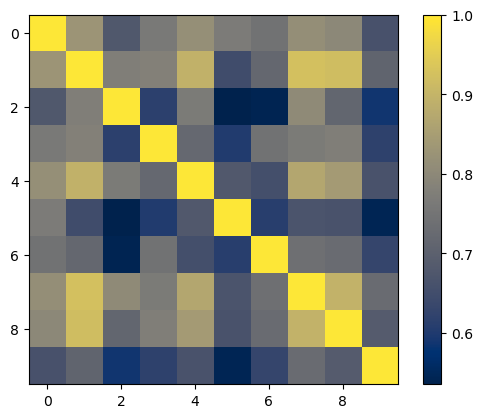

In [12]:
import matplotlib.pyplot as plt

# Get the number of topics from the best HDP model
num_topics = best_hdp_model.live_k

# Compute the pairwise cosine distances between topic-word distributions
distances = np.zeros((num_topics, num_topics))
for i in range(num_topics):
    for j in range(i + 1, num_topics):
        topic_word_dist_i = best_hdp_model.get_topic_word_dist(i)
        topic_word_dist_j = best_hdp_model.get_topic_word_dist(j)
        cosine_dist = 1 - np.dot(topic_word_dist_i, topic_word_dist_j) / (
            np.linalg.norm(topic_word_dist_i) * np.linalg.norm(topic_word_dist_j)
        )
        distances[i, j] = cosine_dist
        distances[j, i] = cosine_dist

# Compute the similarities from distances
similarities = 1 - distances

# Plot the inter-topic distance map
plt.imshow(similarities, cmap='cividis', interpolation='nearest')
plt.colorbar()
plt.show()

### 4. Final Results
#### Top 10 words assigned to each topic with adjusted lambda

In [13]:
topics = []
# Iterate over each topic in the HDP model
for topic_id in range(best_hdp_model.live_k):
    # Get the words for the current topic
    topic_words = best_hdp_model.get_topic_words(topic_id)
    # Extract only the word from each word-probability pair
    topic_words = [word for word, _ in topic_words]
    # Append the list of topic words to the topics list
    topics.append(topic_words)

# Create a DataFrame to store topic-keywords information
df_topic_keywords = pd.DataFrame(topics)
# Set column names as 'Word 1', 'Word 2', ...
df_topic_keywords.columns = ['Word '+str(i+1) for i in range(df_topic_keywords.shape[1])]
# Set row index as 'Topic 1', 'Topic 2', ...
df_topic_keywords.index = ['Topic '+str(i+1) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Topic 1,people,wait,hour,crowd,minute,disney,ticket,close,go,pay
Topic 2,great,love,visit,fun,place,go,kid,always,good,year
Topic 3,florida,disney_world,orlando,visit,small,disney,disneyworld,great,original,love
Topic 4,fast_pass,bring,water,food,use,long,also,lot,ticket,great
Topic 5,disney,kid,visit,great,love,fun,amazing,good,crowd,experience
Topic 6,tell,ask,ticket,employee,say,lose,stand,cast_members,people,find
Topic 7,fast_pass,fastpass,use,early,ticket,hour,app,wait,fast_passe,photo
Topic 8,love,visit,great,disney,good,see,kid,attraction,fun,show
Topic 9,love,great,princess,go,kid,character,good,place,daughter,see
Topic 10,tour,hotel,place,stay,good,walk,love,always,say,great


#### Assignment of the reviews to the topics

In [14]:
# set columnwidth to maximum to see the whole review
pd.set_option('display.max_colwidth', None)

# reset index of dataframe for matching
df= df.reset_index(drop=True)

df_document_topic = df_document_topic.reset_index(drop=True)
df_document_topic = df_document_topic['dominant_topic']

# join the dataset with the document_topic dataframe based on indexes
df_joined = pd.merge(df, df_document_topic, left_index=True, right_index=True)
df_joined.head(10)

,Review_Text,dominant_topic
0,"this place has always been and forever will be special. the feeling you get entering the park, seeing the characters and different attractions is just priceless. this is definitely a dream trip for all ages, especially young kids. spend the money and go to disneyland, you will not regret it",6
1,"a great day of simple fun and thrills. bring cash, nothing is cheap, but we knew that it's disney. but they are great letting you bring in your own food, drinks, etc but read the list closely, we list several items at the entry gates (selfy sticks, glass refill bottles, etc). it is worth buying the photo pass and fastpass. have fun!",4
2,all and all a great day was had. the crowds are huge and ride times sometimes up to a 50 min wait but worth it. very disappointed the castle was under repair and covered but we understood. if you want to take a short cut on the rides grab a max pass for 15 each it allows you to book a time every 90mins and believe me it's a great feeling floating past the ques.,2
3,"having been to the florida location numerous times over the years i didn't know how this one would compare. the much smaller footprint made it quicker easier to get from ride to ride. the cinderella's castle was much much smaller, but also being renovated. many of the rides were identical, while some were notably different. the indiana jones ride (which fl does not have) was awesome. space mountain was much more puke worthy. it's a small world was way more beautiful from the exterior. they had several of the old rides that fl doesn't have (like pinocchio and mr. toad). i love how their fast passes worked... it was easy to use and we were able to use them back to back on rides, fast passing almost everything we wanted to ride. we went the first week of april and while crowded, i didn't think it was too bad. we were only in the park for like 7 hours and i do wish i'd had about 3 more hours to do everything.",3
4,"had the 4 day pass, spent 3 at dl and one at ca. great place to visit. we will be back. saw a lot in those days, but there is more that we missed, and more we want to see again.",2
5,oh my god you can really forget your self and enjoy everything you face there its a huge word of fun,3
6,"we were so sad that the castle was under refurbishment, but we didn t let it ruin our good time. i purchased the maxpass before we went and it was super easy to use and very convenient. maxpass includes free pictures taken by disney photographers. i have been to disney world and there is no shortage of photographers. this was not the case here. they definitely need to add more. we were able to do all of the rides that we wanted to do, and we got the snacks that we wanted to try. we spent two days here and on the last day we watched the fireworks show. it was amazing. all of the workers were polite and helpful.",10
7,"took my son to the park on a weekend(fri sun). very busy all over the places. my son enjoyed it, but he was very sad that he could not try a lot of attractions as the wait time was huge.....( ranging from 60 90 minutes) if you have a lot of time to waste waiting in the line for the attractions, fastpass system at the park is just a ripoff. you can have only one attraction added to your plan at any point, once you complete that attraction you can add one more.",2
8,"there's nothing like disneyland and it should be on your bucket list if you've never been. park is well maintained and parking is ok, but not cheap at $25. tickets can cost up to $150 per adult (10 years old and up) during peak periods. food is not cheap either. if you take a family without a season's pass, you could easily spend hundreds of dollars just on admission tickets. if you go frequently, get a disney credit card to get free park perks and park promotions. downtown disney is also a fun place to visit.",3
9,"i think it s because going to disneyland is one of my earliest memories, but i just love visiting the park every few years. you won